In [3]:
import anndata
import scvelo as scv
import numpy as np
from deepvelo.utils import velocity, velocity_confidence, latent_time, update_dict
from deepvelo.utils.preprocess import autoset_coeff_s
from deepvelo.utils.plot import statplot, compare_plot
from deepvelo import train, Constants
import os
import time

In [2]:
dataset = "Erythroid_Human"
root = '/scratch/blaauw_root/blaauw1/gyichen'
adata = anndata.read_h5ad(f'{root}/data/{dataset}_pp.h5ad')

In [4]:
save_dir = f"{root}/data/deepvelo/{dataset}"
configs = {
    "name": "DeepVelo-Pancreas", # name of the experiment
    "arch":{"args":{"pred_unspliced":True}},
    "loss": {"args": {"coeff_s": autoset_coeff_s(adata)}},
    "trainer": {"verbosity": 0, "save_dir": save_dir}, # increase verbosity to show training progress
}
configs = update_dict(Constants.default_configs, configs)

The ratio of spliced reads is 87.2% (more than 85%). Suggest using coeff_s 1.0.


In [5]:
t_start = time.time()
velocity(adata, mask_zero=False)
trainer = train(adata, configs)
run_time = time.time() - t_start

computing velocities
    finished (0:00:20) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
building graph


INFO:train:Beginning training of DeepVelo-Pancreas ...


velo data shape: torch.Size([35877, 2000])
velo_mat shape: (35877, 2000)
--> added 'velocity' (adata.layers)
--> added 'velocity_unspliced' (adata.layers)
--> added 'cell_specific_beta' (adata.layers)
--> added 'cell_specific_gamma' (adata.layers)
--> added 'cell_specific_alpha' (adata.layers)


In [6]:
latent_time(adata)
adata.obs['dv_time'] = adata.obs['latent_time'].to_numpy()
del adata.obs['latent_time']
adata.uns['dv_run_time']=run_time
os.makedirs(save_dir, exist_ok=True)
adata.write_h5ad(f'{save_dir}/{dataset}.h5ad')
print(f'Total run time: {run_time}')

computing velocity graph (using 1/32 cores)


  0%|          | 0/35877 [00:00<?, ?cells/s]

    finished (0:00:22) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 10 regions of root cells and 1 region of end points .
    finished (0:00:11) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:07) --> added 
    'latent_time', shared time (adata.obs)
Total run time: 143.05139446258545


In [7]:
scv.tl.velocity_graph(adata, n_jobs=8)

computing velocity graph (using 8/32 cores)


  0%|          | 0/35877 [00:00<?, ?cells/s]

    finished (0:03:51) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:09) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


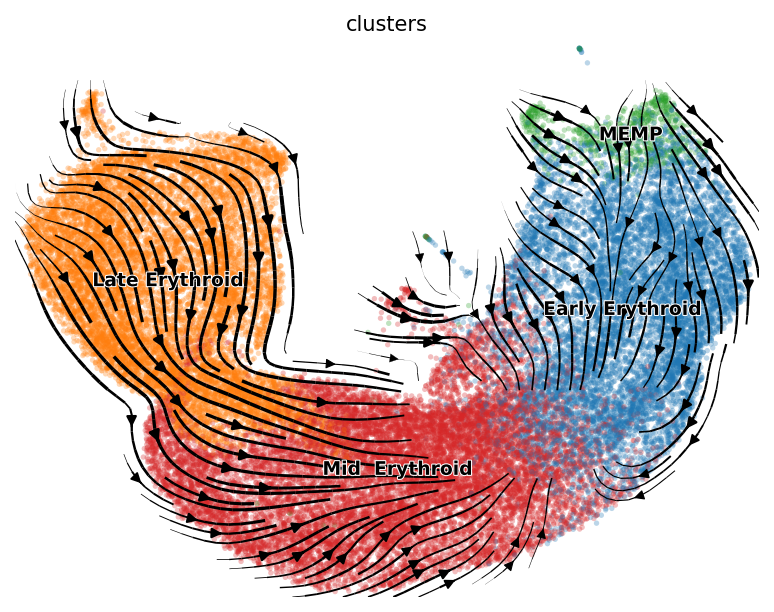

In [8]:
scv.pl.velocity_embedding_stream(adata,
                                 basis='umap',
                                 legend_fontsize=9,
                                 dpi=150)

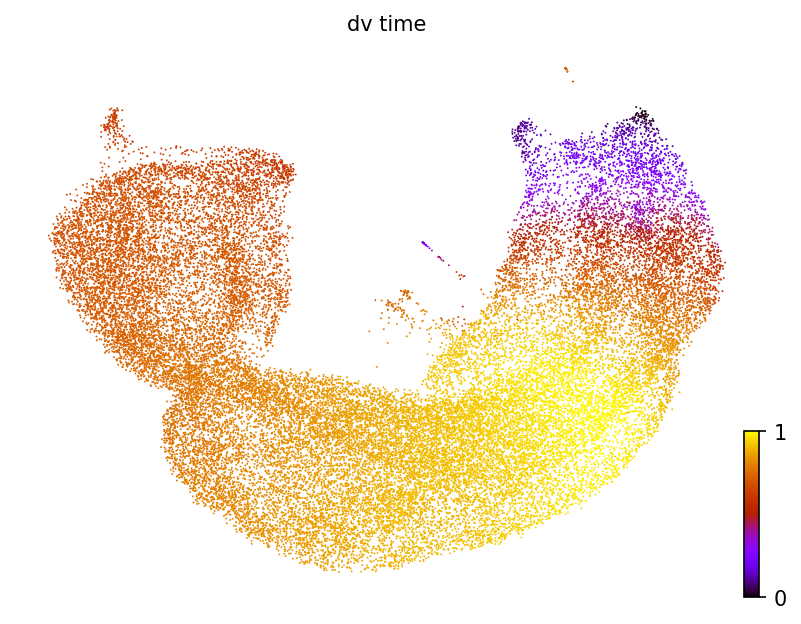

In [9]:
scv.pl.scatter(adata,
               color='dv_time',
               dpi=150,
               color_map='gnuplot')